In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

from scipy.stats import probplot


def random_color():
    """
    get random matplot-lib colour - just for fun
    """
    color_names = list(mcolors.get_named_colors_mapping().keys())
    color_count = len(color_names)
    random_num = random.randint(0, color_count - 1)
    rand_col = mcolors.get_named_colors_mapping()[color_names[random_num]]
    # if rand_col == "No.":
    #     rand_col = random_color()
    return rand_col


def random_colormap():
    """
    get random matplot-lib colourmap
    """
    colormap_count = len(plt.colormaps())
    random_num = random.randint(0, colormap_count - 1)
    rand_colmap = plt.colormaps()[random_num]
    print(f"colormap used: {rand_colmap}")
    return rand_colmap

## Normal Equation
- requires invertible x: square non-singular matrix (singularity: linear dependency in rows/columns; det != 0)
- for non-square X: Moore-Penrose Pseudoinverse (pinv())

#### → Linear hypothesis function

In [2]:
def h(x, theta):
    """
    Get linear hypothesis (weights @ features)
    """
    return x @ np.matrix(theta).T

#### → Mean Squared Error function between the predicted values and the labels.

In [3]:
def mean_squared_error(y_predicted, y_label):
    """
    Get mean squared error from 2 arrays
    """
    if np.array(y_predicted).reshape(-1).shape != np.array(y_label).reshape(-1).shape:
        raise ValueError("input value counts not matching")
    return np.mean((y_predicted - y_label) ** 2)

#### → LeastSquareRegression class

In [4]:
class LeastSquaresRegression():
    """An OLS Linear Regression class with Normal Equation."""
    def __init__(self,):
        """Initializes a LeastSquaresRegression object."""
        self.theta_ = None

    def fit(self, X, y):
        """Calculate feature weights with Normal Equation.
        :param X: numpy.array with 2-D tabular data
        :param y: numpy.array with 1-D data
        """
        self.theta_ = np.linalg.inv(X.T @ X) @ X.T @ y

    def predict(self, X):
        """Calculate predicted values.
        :param X: numpy.array with 2-D tabular data
        :return: numpy.array with 1-D predictions
        """
        return X @ self.theta_

### → Plot artificial linear dataset

In [5]:
X = 4 * np.random.rand(100, 1)
y = 10 + 2 * X + np.random.randn(100, 1)

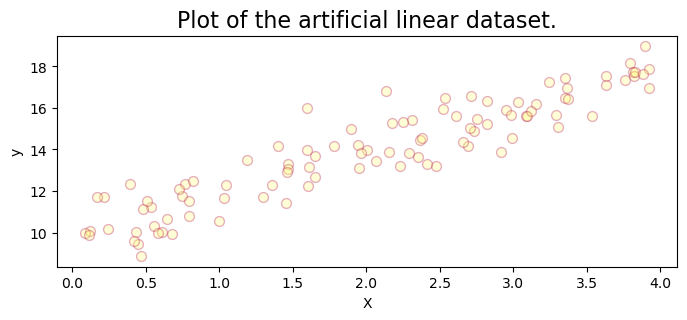

In [6]:
plt.figure(figsize=(8, 3))
alpha, edgecolors, size = 0.3, random_color(), 50
plt.scatter(X, y, color=random_color(), alpha=alpha, label="y", edgecolors=edgecolors, s=size)
plt.xlabel("X")
plt.ylabel("y")
plt.title("Plot of the artificial linear dataset.", fontsize=16);

##### → Additional verification if X is linear with Probability plot  
- Could have been deducted from previous plot, this is just playing around.
- However, Probability plot does identify that noise in artificial data has affected the linearity.

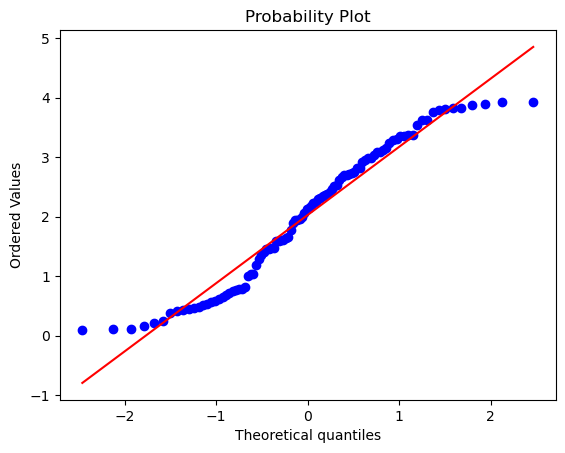

In [7]:
probplot(X.reshape(-1), plot=plt);

#### → Function adding one to each instance

In [8]:
def bias_column(X):
    """
    Add one to each instance.
    :param X: numpy.array with 1-D or 2-D tabular data.
    :return: numpy.array with 2-D tabular data.
    """
    return np.hstack((np.ones(shape=[X.shape[0], 1]), X))

X_new = bias_column(X)

print(X[:5])
print(" ---- ")
print(X_new[:5])

[[1.04331557]
 [3.08337681]
 [2.47073272]
 [0.76642681]
 [3.81449374]]
 ---- 
[[1.         1.04331557]
 [1.         3.08337681]
 [1.         2.47073272]
 [1.         0.76642681]
 [1.         3.81449374]]


#### → Calculate the weights with the LeastSquaresRegression class

In [9]:
model = LeastSquaresRegression()
model.fit(X=X_new, y=y)
model.theta_

array([[9.8945331 ],
       [1.99345702]])

#### → Are the values consistent with the generating equation (i.e 10 and 2) ?
##### **Yes, the model correctly identified the pattern from generating equation with intercept difference ~ 4% and slope ~7%.**

#### → Predict values from X and plot the two sets of points superimposed.

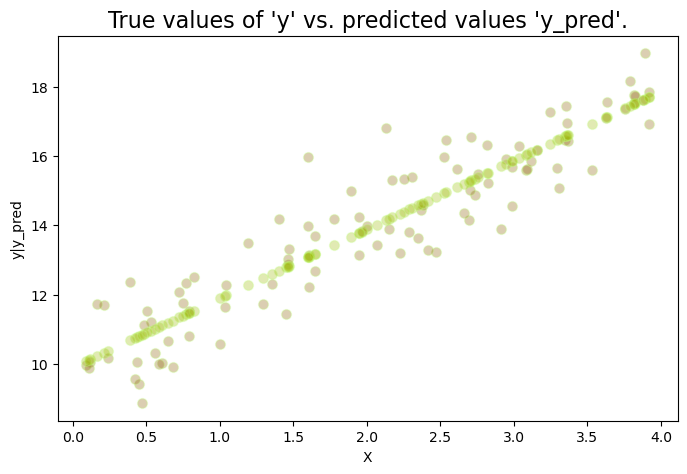

In [10]:
y_new = model.predict(X_new)

def my_plot(X, y, y_new):
    plt.figure(figsize=(8, 5))
    alpha, edgecolors, size = 0.3, random_color(), 50
    plt.scatter(X, y, color=random_color(), alpha=alpha, label="y", edgecolors=edgecolors, s=size)
    plt.scatter(X, y_new, color=random_color(), alpha=alpha, label="y_pred", edgecolors=edgecolors, s=size)
    plt.xlabel("X")
    plt.ylabel("y|y_pred")
    plt.title("True values of 'y' vs. predicted values 'y_pred'.", fontsize=16)
my_plot(X, y, y_new)

##### → What is the computational complexity of this method? 
##### **The computational complexity for Normal equation is $O(F^2 * N) + O(F^3)$, where:**
##### **- N is number of rows/instances and**
##### **- F is the number of columns/features.**
##### **Among the most costly operations are  calculating the matrix inverse that contributes to $O(F^3)$ factor and multiplying matrices $X^T*X$  that contributes to $O(F^2 * N)$. Thus Normal equation is particularly costly, if the number of features is high.**

#### → How does the training complexity compare to the predictions complexity?
##### **The computational complexity during prediction for Linear regression is $O(N)$. Thus it is linearly affected by the number of rows/instances in the dataset.**

## Gradient Descent

In [11]:
class GradientDescentOptimizer():
    """A class implementing Gradient Descent for a linear function."""
    def __init__(self, f, fprime, start, learning_rate = 0.1):
        """Initialize an GradientDescentOptimizer object.
        :param f: object calculating output of a linear function.
        :param fprime: object calculating gradient/derivative of 'f'.
        :param start: numpy.array with 2-D point to be evaluated.
        :param learning_rate: float of weight for gradient descent step size.
        """
        self.f_      = f
        self.fprime_ = fprime
        self.current_ = start
        self.learning_rate_ = learning_rate
        self.history_ = [start]

    def step(self):
        """Get gradient descent step.
        1. Add basic dynamism to the learning rate - 
                increase step size if sum of gradients is larger than 10 
        2. Compute the new value and update self.current_
        3. Append the new value to history
        """
        #  adding error weight may improve convergence speed, however erratic behavior with first random theta pair
        # error = self.f_(self.current_) - self.f_(np.array([[2,6]]))
        self.gradient = self.fprime_(self.current_)  # * error * self.learning_rate_
        d = 10 if sum(self.gradient) > 10 else 1
        theta = self.current_ - d * self.learning_rate_ * self.gradient
        self.history_.append(theta)
        self.current_ = theta

    def optimize(self, iterations = 100):
        """Use gradient descent step to get closer to 
        the function minimum. Early stop if suum of gradients 
        is smaller than 0.001.
        :param iterations: int of  gradient descent steps.
        """
        for i in range(iterations):
            self.step()
            if abs(sum(self.gradient)) < 0.001:
                break

    def getCurrentValue(self):
        """
        Get GradientDescentOptimizer.current_ attribute.
        :return: numpy.array with 2-D point coordinates.
        """
        return self.current_
 
    def print_result(self):
        """Print specified GradientDescentOptimizer attributes."""
        print("Best theta found is " + str(self.current_))
        print("Value of f at this theta: f(theta) = " + str(self.f_(self.current_)))
        print("Value of f prime at this theta: f'(theta) = " + str(self.fprime_(self.current_)))

#### → f function

$f(x) = 3 + (x - ([[2,6]])^T)^T · (x - ([[2,6]])^T)$

In [12]:
def f(x):
    """Get result of a linear function.
    :param x: numpy.array with 2-D tabular data in [n, 2] shape.
    :return: float.
    """
    funkshan_result = 3 + (np.matrix(x).T - np.matrix([2,6]).T).T @ (np.matrix(x).T - np.matrix([2,6]).T) # would also work if x is matrix (eg batch gradient descent)
    # funkshan_result = 3 + (x - np.array([2,6]).T).T @ (x - np.array([2,6])).T  # fine in this instance
    if max(funkshan_result.shape) == 1:
        return funkshan_result.item()
    return funkshan_result

#### → fprime function
- in essence $f(x)$ is a square function, thus it's derivative is:
$$f'(x) = 2 * (x - ([[2,6]])^T)$$

In [13]:
def fprime(x):
    """Get result of a linear function.
    :param x: numpy.array with 2-D tabular data in [n, 2] shape.
    :return: float.
    """
    return 2 * (x - np.array([2,6]))

#### → Use the the gradient descent optimizer to try to find the best theta value

In [14]:
grad = GradientDescentOptimizer(f, fprime, np.random.normal(size=(2,)), 0.1)
grad.optimize(10)
grad.print_result()

Best theta found is [1.87096791 5.35451955]
Value of f at this theta: f(theta) = 3.4332942956775163
Value of f prime at this theta: f'(theta) = [-0.25806417 -1.29096091]


In [15]:
grad.getCurrentValue()

array([1.87096791, 5.35451955])

#### → Plot the function f in 3D
#### → Plot the progression of the gradient by using the history variable inside the class

In [16]:
x_plot = np.linspace(-3, 13, 50)
x_1, x_2 = np.meshgrid(x_plot, x_plot)
y_plot = np.apply_along_axis(func1d=f, axis=0, arr=np.array([x_1, x_2]))

In [17]:
x_thetas = np.array(grad.history_)
y_thetas = np.apply_along_axis(func1d=f, axis=1, arr=grad.history_)

colormap used: winter_r


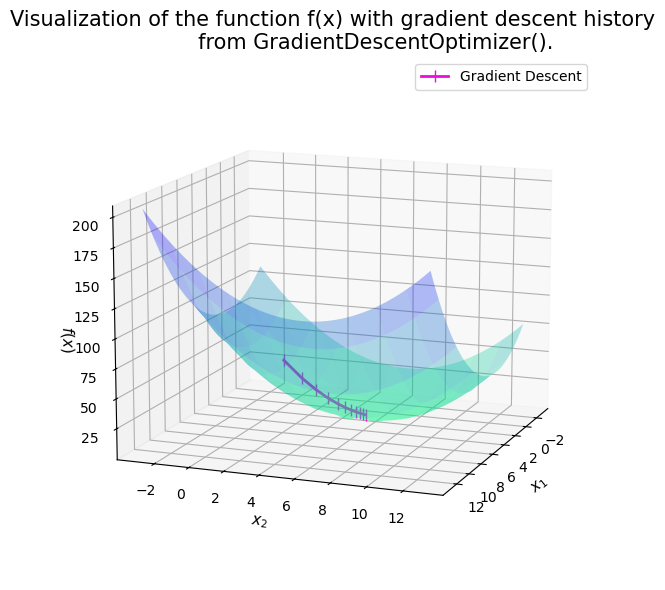

In [18]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')

ax.plot_surface(x_1, x_2, y_plot,  
                rstride=5, 
                cstride=9, 
                cmap=random_colormap(), # to change cmap, run the cell again, poss alternatives: "Greys_r", "Blues_r", cividis
                alpha=0.3
                )
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_zlabel(r"$f(x)$", fontsize=11, labelpad=-1)
ax.set_title("Visualization of the function f(x) with gradient descent history\n\
             from GradientDescentOptimizer().",
              fontsize=15
              )
gradient_line = ax.plot(x_thetas[:, 0], x_thetas[:, 1], y_thetas,
                        color=random_color(), # to change color, run the cell again, poss alternatives: 'k', 'm'
                        linewidth=2, 
                        marker = '|',
                        markersize=9
                        )
ax.legend((gradient_line), ["Gradient Descent"])
elevation, azimuth, roll = 13, 21, 0  # to see from above, increase elevation up to 90 (65 Ok-ish value)
ax.view_init(elevation, azimuth)
fig.tight_layout()

#### Gradient moving toward the cavity of the function f is clearly visible.

#### → How does the learning rate and the number of iterations influence the result?
##### **Learning rate is ***step size*** and iterations are ***number of steps*** used by the gradient descent algorithm to reach function optimum:**
##### - **Too few steps/iterations stop the algorithm before reaching optimum.**
##### - **Too many steps/iterations will consume computational resources unnecessarily.**
##### - **Too small steps/learning rate may result in running out of steps/iterations before reaching optimum.**
##### - **Too large steps/learning rate may result in overstepping optimum and oscillating around it back and  forth.**

#### → How to [tune hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_optimization) and choose a good learning rate?
##### **A number of generic algorithms are used for hyperparameter search in case of learning rate:**
##### - **Grid search: provide a number of hyperparameter values and compare model evaluation metrics.**
##### - **Random search: provide a number of random hyperparameter values within a specific range and compare model evaluation metrics. Can be used in combination with grid search to narrow down potentially useful hyperparameter ranges.**
##### - **Bayesian optimization: use probabilistic model to identify potentially useful hyperparameter values based on existing model configuration. More appropriate, when multiple hyperparameter tuning conducted.**
##### - **Evolutionary optimization: Randomize initial hyperparameter set and then iteratively replace worse-performing ones with re-combining and fusing the better-performing ones. More appropriate, when multiple hyperparameter tuning conducted.**
##### - **More specific to gradient learning rate: introduce additional logic (e.g. adaptive weight function) to update learning rate based on slope of function derivative at each step.**

#### → What about the number of iterations? 
##### **Generic algorithms described in previous question can also be used to search for improved iteration count. Also, ***Early stopping*** logic can be introduced that stops further parameter calculation steps based on some other metric - e.g. learning rate reaching some minimum threshold.**

#### → What is the Convergence Rate?
##### **Rate at which desired level of optimization (e.g $f'(x) = 0$) or count of iterations is reached for a particular function/ML algorithm. The Convergence rate can measure improvements of a model error metric (e.g. $\epsilon=y_{predicted} - y_{true}$) over time, step, iteration, epoch, batch, etc.**
